# Project: Banking 
## Part 2: Building a prediction model

### In Part 1 we have seen:
- Dataset overview
- Exploratory Data Analysis
- Statistical description of data
- Features distributions
- Features target percentage
- Trends and patterns


### Index Part 2:
## Correlation analysis
## Features engineering
- Transform
- Scaling
- Selection

## Splitting the dataset
## Testing classification models
- Imbalanced dataset
- balanced dataset
- Cross Validation
- Hyperparameters tunning

## Choosing final model

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
clients= pd.read_csv('bank-full.csv', engine='python')

In [3]:
clients.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
#We transform target in 0/1
clients['y']=clients['y'].map({'yes':1,'no':0})

In [4]:
#Categorical columns
cat_columns= list(clients.select_dtypes(object).columns)
print(cat_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [5]:
#Numerical columns
num_columns= list(clients.select_dtypes(int).columns)
print(num_columns)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']


## Target distribution

In [6]:
clients.y.value_counts(normalize=True)

0    0.883015
1    0.116985
Name: y, dtype: float64

It’s a **highly imbalanced** dataset (target has 11.7% of yes and 88.3% of no)

## Correlation analysis (heat map)


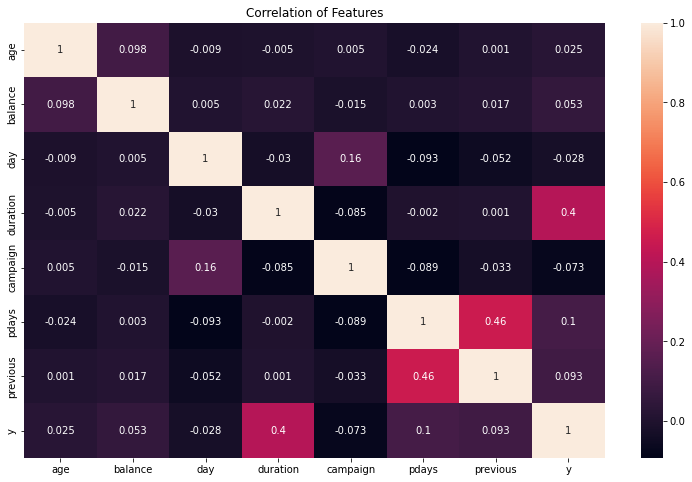

In [7]:
plt.figure(figsize=(13,8))
sns.heatmap(clients.corr().round(3), annot=True)
plt.title('Correlation of Features')
plt.show()

In [8]:
# Features correlation with the target
clients.corr()['y']

age         0.025155
balance     0.052838
day        -0.028348
duration    0.394521
campaign   -0.073172
pdays       0.103621
previous    0.093236
y           1.000000
Name: y, dtype: float64

From correlation matrix we observe:
- There isn't significative correlation between the numerical features
- There isn't significative correlation between the numerical features and the target (y)

# Features engineering

## Transform

In [9]:
#We transform columns yes/no in 0/1 

clients['default']= clients['default'].map({'yes':1,'no':0})
clients['housing']= clients['housing'].map({'yes':1,'no':0})
clients['loan']= clients['loan'].map({'yes':1,'no':0})
clients.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


## Scaling

We scale the numerical features with RobustScaler because they have many otuliers and have very different rangs.

In [10]:
columns_Robust = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
clients[columns_Robust]= RobustScaler().fit_transform(clients[columns_Robust])

We make dummies with categorical features

In [11]:
columns_dummies= ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
clients = pd.get_dummies(clients, columns= columns_dummies)

In [12]:
clients.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.266667,0,1.250000,1,0,-0.846154,0.375000,-0.5,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0.333333,0,-0.308997,1,0,-0.846154,-0.134259,-0.5,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,-0.400000,0,-0.328909,1,1,-0.846154,-0.481481,-0.5,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0.533333,0,0.780236,1,0,-0.846154,-0.407407,-0.5,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,-0.400000,0,-0.329646,0,0,-0.846154,0.083333,-0.5,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## Selection

We select **all the features** because there is not correlation between them and all of them may have influence in the target 

# Splitting the data set

For training and testing the models we'll use 2 different datasets:
- Imbalanced dataset. Train/Test (30% Test)
- Balanced dataset:  undersampling to get 30% of and target=1 and train/Test (30% Test)

In [13]:
#Imbalanced dataset
y= clients['y']
x= clients.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

In [14]:
X_train.shape

(31647, 48)

In [15]:
y_train.value_counts(normalize=True)

0    0.883275
1    0.116725
Name: y, dtype: float64

We observe that in train dataset the target percentaje is similar to percentage in total data.

In [16]:
#Balanced dataset
X_train_b ,y_train_b = RandomUnderSampler(sampling_strategy= 0.43, random_state=0).fit_resample(X_train, y_train)

In [76]:
X_train_b.shape

(12284, 48)

In [77]:
y_train_b.value_counts(normalize=True)

0    0.699284
1    0.300716
Name: y, dtype: float64

The balanced train dataset has 12.284 rows and 30% of yes

# Testing classification models

We are testing this classification models: Logistic Regression, Decision Tree, Random Forest, AdaBoostClassifier, GradientBoostingClassifier, K-Nearest Neighbor, Balanced Bagging Classifier.   
We are interesting in **optimize the accuracy but having the less False Positives**. For the bank it's very important to predict a right number of positive just to know the total amount they will obtain and they can use for investments.

## Imbalanced dataset

In [16]:
# Building, training and testing the models
models = {}                                             #Dictionary with models to test
models['Logistic Regression'] = LogisticRegression(max_iter=500)
models['Decision Tree'] = DecisionTreeClassifier()
models['Random Forest'] = RandomForestClassifier(random_state=0)
models['AdaBoostClassifier'] = AdaBoostClassifier(random_state=0)
models['GradientBoostingClassifier'] = GradientBoostingClassifier(random_state=0)
models['K-Nearest Neighbor'] = KNeighborsClassifier()
models['Balanced Bagging Classifier'] = BalancedBaggingClassifier(base_estimator= RandomForestClassifier(),random_state=0)

accuracy, precision, recall, f1, roc = {}, {}, {}, {}, {}

for key in models.keys():
    models[key].fit(X_train, y_train)                           # Training the models
    predictions = models[key].predict(X_test)                   # Prediction 
       
    accuracy[key] = accuracy_score(predictions, y_test)         # Calculate Metrics
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1[key] = f1_score(predictions, y_test)
    roc[key] = roc_auc_score(predictions, y_test)
    
metrics = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Roc_Auc'])    # DF with metrics
metrics['Accuracy'] = accuracy.values()
metrics['Precision'] = precision.values()
metrics['Recall'] = recall.values()
metrics['F1'] = f1.values()
metrics['Roc_Auc'] = roc.values()
metrics


,Accuracy,Precision,Recall,F1,Roc_Auc
Logistic Regression,0.899145,0.349843,0.627672,0.449275,0.772928
Decision Tree,0.872162,0.489655,0.459142,0.473908,0.695262
Random Forest,0.902757,0.389342,0.642857,0.484967,0.782772
AdaBoostClassifier,0.899071,0.391223,0.610568,0.476882,0.766574
GradientBoostingClassifier,0.902536,0.420063,0.627929,0.503381,0.776956
K-Nearest Neighbor,0.891920,0.344201,0.566563,0.428237,0.741757
Balanced Bagging Classifier,0.854763,0.863950,0.440115,0.583157,0.709658


We calculate the confusion matrix of the models

In [12]:
TP, TN, FP, FN = {}, {}, {}, {}

for key in models.keys():
    cm=confusion_matrix(y_test, models[key].predict(X_test))    #Calculate Confusion Matrix
    TP[key]= cm[1][1]
    TN[key]= cm[0][0]
    FP[key]= cm[0][1]
    FN[key]= cm[1][0]

confusion_m= pd.DataFrame(index=models.keys())       #DF with confusion matrix results
confusion_m['TP']= TP.values()
confusion_m['TN']= TN.values()
confusion_m['FP']= FP.values()
confusion_m['FN']= FN.values()

print('(*) TP: True positive, TN: True negative, FP; False positive, FN: False negative')
confusion_m

(*) TP: True positive, TN: True negative, FP; False positive, FN: False negative


,TP,TN,FP,FN
Logistic Regression,558,11638,331,1037
Decision Tree,787,11065,904,808
Random Forest,621,11624,345,974
AdaBoostClassifier,624,11571,398,971
GradientBoostingClassifier,670,11572,397,925
K-Nearest Neighbor,549,11549,420,1046
Balanced Bagging Classifier,1378,10216,1753,217


As we are interested in optimizing the accuracy having the less False Positives, the best models are **Random Forest** and **GradientBoostingClassifier**

## Balanced dataset

In [17]:
# Building, training and testing the models
models_b = {}                                        #Diccionario con los modelos a testear
models_b['Logistic Regression'] = LogisticRegression(max_iter=500)
models_b['Decision Tree'] = DecisionTreeClassifier()
models_b['Random Forest'] = RandomForestClassifier()
models_b['AdaBoostClassifier'] = AdaBoostClassifier(random_state=0)
models_b['GradientBoostingClassifier'] = GradientBoostingClassifier(random_state=0)
models_b['K-Nearest Neighbor'] = KNeighborsClassifier()
models_b['Balanced Bagging Classifier'] = BalancedBaggingClassifier(base_estimator= RandomForestClassifier(),random_state=0)

accuracy, precision, recall, f1, roc = {}, {}, {}, {}, {}

for key in models_b.keys():
    models_b[key].fit(X_train_b, y_train_b)                           # Training the models
    predictions = models_b[key].predict(X_test)                   # Prediction 
       
    accuracy[key] = accuracy_score(predictions, y_test)         # Calculate Metrics
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1[key] = f1_score(predictions, y_test)
    roc[key] = roc_auc_score(predictions, y_test)
    
metrics_b = pd.DataFrame(index=models_b.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Roc_Auc'])    # DF with metrics
metrics_b['Accuracy'] = accuracy.values()
metrics_b['Precision'] = precision.values()
metrics_b['Recall'] = recall.values()
metrics_b['F1'] = f1.values()
metrics_b['Roc_Auc'] = roc.values()
metrics_b

,Accuracy,Precision,Recall,F1,Roc_Auc
Logistic Regression,0.883368,0.638871,0.503210,0.562983,0.726646
Decision Tree,0.841787,0.688401,0.399709,0.505758,0.676881
Random Forest,0.884031,0.757994,0.504591,0.605863,0.735014
AdaBoostClassifier,0.881672,0.652038,0.497608,0.564450,0.724619
GradientBoostingClassifier,0.885358,0.757367,0.508418,0.608411,0.736913
K-Nearest Neighbor,0.868623,0.642006,0.458166,0.534726,0.703882
Balanced Bagging Classifier,0.845842,0.882132,0.425076,0.573700,0.703371


We calculate the confusion matrix of the models

In [14]:
TP, TN, FP, FN = {}, {}, {}, {}

for key in models_b.keys():
    cm=confusion_matrix(y_test, models_b[key].predict(X_test))    #Calculate Confusion Matrix
    TP[key]= cm[1][1]
    TN[key]= cm[0][0]
    FP[key]= cm[0][1]
    FN[key]= cm[1][0]

confusion_m_b= pd.DataFrame(index=models.keys())       #DF with confusion matrix results
confusion_m_b['TP']= TP.values()
confusion_m_b['TN']= TN.values()
confusion_m_b['FP']= FP.values()
confusion_m_b['FN']= FN.values()

print('* TP: True positive, TN: True negative, FP; False positive, FN: False negative')
confusion_m_b

* TP: True positive, TN: True negative, FP; False positive, FN: False negative


,TP,TN,FP,FN
Logistic Regression,1019,10963,1006,576
Decision Tree,1079,10318,1651,516
Random Forest,1222,10807,1162,373
AdaBoostClassifier,1040,10919,1050,555
GradientBoostingClassifier,1208,10801,1168,387
K-Nearest Neighbor,1024,10758,1211,571
Balanced Bagging Classifier,1407,10066,1903,188


Comparing imbalanced and balanced datasets:
- Imbalanced dataset has better results in all metrics comparing with balanced dataset
- Balanced dataset increase the number of True Positive but also the number of False Positive
- Probably, with the models tested, it has more and better influence to use more rows than to use balanced datasets

Therfore, we'll use the original **imbalanced dataset** for building the end model


## Cross Validation and hyperparameters tunning

We select **Random Forest Classifier** and **GradientBoostingClassifier** for ajusting hyperparameters and determinate which one is best model.

## Cross Validation

Using Cross Validation we'll see if our models have overfitting. We'll use the dataset complete and the score will be accuracy

In [17]:
#Random Forest Classifier
crossv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 0)
scores = cross_val_score(models['Random Forest'], x, y, scoring= 'accuracy', cv = crossv)
print('Accuracy: {0}     std_Accuracy: {1}'.format(np.mean(scores).round(4), np.std(scores).round(4)))

Accuracy: 0.9056     std_Accuracy: 0.0039


In [18]:
#Gradient Boosting Classifier
crossv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 0)
scores = cross_val_score(models['GradientBoostingClassifier'], x, y, scoring= 'accuracy', cv = crossv)
print('Accuracy: {0}     std_Accuracy: {1}'.format(np.mean(scores).round(4), np.std(scores).round(4)))

Accuracy: 0.9065     std_Accuracy: 0.0041


When applying cross validation on the total dataset we obtain an accuracy similar to the one obtained by Train/Test. The standard deviation of the 30 values is very low, so we can conclude that there is **no overfitting** in our models.

## Hyperparameters tunning

We try to improve the models using GridSearch, optimizing accuracy

### 1.- Random Forest

In [25]:
#We get the model inicial parameters
models['Random Forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [11]:
#Parameters to optimize with GridSearch
parameters ={'max_features': [10,15,20,25], 'n_estimators': [100, 150, 200, 250, 300], 'max_depth': [10, 15,20, 25]}

#setting up
rf_gs = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameters, scoring = 'accuracy')

#Training
rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20, 25],
                         'max_features': [10, 15, 20, 25],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='accuracy')

In [14]:
print ('Best Parameters: ', rf_gs.best_params_, ' \n')
print ('Best accuracy: ', rf_gs.best_score_, ' \n')


Best Parameters:  {'max_depth': 20, 'max_features': 15, 'n_estimators': 200}  

Best accuracy:  0.9083959166873219  



We train the the Random Forest model with the best params and calculate metrics and confusion matrix

In [15]:
rf= RandomForestClassifier(max_depth=20, max_features=15, n_estimators =200)
rf.fit(X_train, y_train)

#Calculate metrics
accuracy = accuracy_score(rf.predict(X_test), y_test)
precision = precision_score(rf.predict(X_test), y_test)
recall = recall_score(rf.predict(X_test), y_test)
f1 = f1_score(rf.predict(X_test), y_test)
roc = roc_auc_score(rf.predict(X_test), y_test)
metrics.loc['Random Forest Optimized'] = [accuracy, precision, recall, f1, roc]

#Calculate confusion matrix
cm=confusion_matrix(y_test, rf.predict(X_test)) 
confusion_m.loc['Random Forest Optimized'] = [cm[1][1], cm[0][0], cm[0][1], cm[1][0]]

### 2.- Gradient Boosting Classifier

In [13]:
#We get the model inicial parameters
models['GradientBoostingClassifier'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [14]:
#Parameters to optimize with GridSearch
parameters ={'criterion': ['friedman_mse', 'squared_error'], 'n_estimators': [75, 100, 150, 200], 
             'learning_rate': [0.1, 0.5, 1.0], 'max_depth': [3, 5, 10]}

#Definimos el GridSearch
gbc_gs = GridSearchCV(estimator = GradientBoostingClassifier(random_state=0), param_grid = parameters, scoring = 'accuracy')

#Entrenamos el GridSearch
gbc_gs.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 0.5, 1.0],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [75, 100, 150, 200]},
             scoring='accuracy')

In [15]:
print ('Best Parameters: ', gbc_gs.best_params_, ' \n')
print ('Best accuracy: ', gbc_gs.best_score_, ' \n')

Best Parameters:  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}  

Best accuracy:  0.9087750586145622  



We train the the GradientBoostingClassifier model with the best params and calculate metrics and confusion matrix

In [16]:
gbc= GradientBoostingClassifier(random_state=0, criterion ='friedman_mse', max_depth=5, learning_rate=0.1, n_estimators =150)
gbc.fit(X_train, y_train)

#Calculate metrics
accuracy = accuracy_score(gbc.predict(X_test), y_test)
precision = precision_score(gbc.predict(X_test), y_test)
recall = recall_score(gbc.predict(X_test), y_test)
f1 = f1_score(gbc.predict(X_test), y_test)
roc = roc_auc_score(gbc.predict(X_test), y_test)
metrics.loc['GradientBoostingClassifier Optimized'] = [accuracy, precision, recall, f1, roc]

#Calculate confusion matrix
cm=confusion_matrix(y_test, gbc.predict(X_test)) 
confusion_m.loc['GradientBoostingClassifier Optimized'] = [cm[1][1], cm[0][0], cm[0][1], cm[1][0]]

## Choosing final model

We are comparing RandomForest and GradienBostClassifier before and after hyperparameters tunning

In [17]:
#metrics
metrics.iloc[[2,4,7,8]]

,Accuracy,Precision,Recall,F1,Roc_Auc
Random Forest,0.902757,0.389342,0.642857,0.484967,0.782772
GradientBoostingClassifier,0.902536,0.420063,0.627929,0.503381,0.776956
Random Forest Optimized,0.904674,0.475235,0.624382,0.539694,0.778304
GradientBoostingClassifier Optimized,0.906444,0.482759,0.634267,0.548238,0.783733


In [18]:
#confusion matrix
confusion_m.iloc[[2,4,7,8]]

,TP,TN,FP,FN
Random Forest,621,11624,345,974
GradientBoostingClassifier,670,11572,397,925
Random Forest Optimized,758,11513,456,837
GradientBoostingClassifier Optimized,770,11525,444,825


#### Model comparison
- Both models slightly improve accuracy (0.4%) when tunning hyperparameters
- GradientBostingClassifier Optimized obtain the best results in all metrics
- GradientBostingClassifier Optimized obtain more True Positive and less False Positive than Random Forest Optimized

We apply Cross Validation to the final model

In [12]:
#Cross Validation final model
model= GradientBoostingClassifier(criterion= 'friedman_mse', learning_rate= 0.1, max_depth= 5, n_estimators= 150, random_state=0)
crossv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 0)
scores = cross_val_score(model, x, y, scoring= 'accuracy', cv = crossv)
print('Accuracy: {0}     std_Accuracy: {1}'.format(np.mean(scores).round(4), np.std(scores).round(4)))

Accuracy: 0.9091     std_Accuracy: 0.0045


We obtain an accuracy similar to the one obtained by Train/Test. The standard deviation of the 30 values is very low, so we can conclude that there is **no overfitting** in our final model.

**Finally, we choose the model:**
- **GradientBoostingClassifier**(criterion= 'friedman_mse', learning_rate= 0.1, max_depth= 5, n_estimators= 150, random_state=0)
- Accuracy: **0.9064**
- False Positives: **1.4%**